In [1]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [3]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [4]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [5]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(out_ch))

    def forward(self, x):
        x = self.conv1(x) + self.conv2(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class Res_UNet_Channel_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(Res_UNet_Channel_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16, n1 * 32]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])
        self.conv6 = conv_block(filters[4], filters[5])

        self.Up6 = up_conv(filters[5], filters[4])
        self.Att6 = Attention_block(F_g=filters[4], F_l=filters[4], F_int=filters[3])
        self.Up_conv6 = conv_block(filters[5], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
        
        self.Ch_att1 = ChannelAttention(in_planes=filters[0], ratio=8)
        self.Ch_att2 = ChannelAttention(in_planes=filters[1], ratio=8)
        self.Ch_att3 = ChannelAttention(in_planes=filters[2], ratio=8)
        self.Ch_att4 = ChannelAttention(in_planes=filters[3], ratio=8)
        self.Ch_att5 = ChannelAttention(in_planes=filters[4], ratio=8)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        e6 = self.Maxpool5(e5)
        e6 = self.conv6(e6)

        d6 = self.Up6(e6)

#         x5 = self.Att6(g=d6, x=self.Ch_att5(e5))
        x5 = self.Att6(g=d6, x=e5)
        d6 = torch.cat((x5, d6), dim=1)
        d6 = self.Up_conv6(d6)

        d5 = self.Up5(d6)
#         x4 = self.Att5(g=d5, x=self.Ch_att4(e4))
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4, x=self.Ch_att3(e3))
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3, x=self.Ch_att2(e2))
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2, x=self.Ch_att1(e1))
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [6]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_function = loss_function
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []
        ious = []

        outs = []
        ts = []

        def calculate_iou(pred, target):
            eps = 1e-6
            # convert to sigmoid then to binary
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                ious.append(calculate_iou(out, task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))

        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss, mIoU

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:

                    out = self.model(task["pred"])

                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
#                 print(self.sched.get_last_lr())

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                #                 torch.save({
                #                     'epoch': epoch,
                #                     'model_state_dict': self.model.state_dict(),
                #                     'optimizer_state_dict': self.opt.state_dict(),
                #                     'loss': epoch_loss
                #                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 20 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")

In [7]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [8]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.8 MB/s eta 0:00:00a 0:00:01


In [9]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss
from monai.losses.hausdorff_loss import HausdorffDTLoss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

    
class MultiScalePoolingLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, itr=3, ratio=None):
        super(MultiScalePoolingLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.itr = itr
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.ratio = torch.tensor(ratio)
    
    def forward(self, pred, target):
        losses = torch.zeros(self.itr)
        if(pred.dim() == 2):
            pred = pred.unsqueeze(0)
            target = target.unsqueeze(0)
        elif(pred.dim() == 3):
            pred = pred.unsqueeze(1)
            target = target.unsqueeze(1)
        for i in range(self.itr):
            losses[i] = self.focal_loss(pred, target)
            pred = F.max_pool2d(pred, kernel_size=2, stride=2)
            target = F.max_pool2d(target, kernel_size=2, stride=2)
        
        if self.ratio is not None:
            losses = losses * self.ratio
        else:
            losses = losses * 1/self.itr
        
        return torch.sum(losses)

    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        # Compute Dice loss
        intersection = (inputs * targets).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + smooth)

        # Compute BCE loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE = BCE.mean(dim=1)

        # Combine Dice and BCE losses
        Dice_BCE = BCE + dice_loss

        return Dice_BCE.mean()

    
class HausdorffDT_Loss(nn.Module):
    def __init__(self):
        super(HausdorffDT_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='mean', sigmoid=True)
        self.focal_loss = FocalLoss

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        return self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))

    
class HausdorffDT_Focal_Loss(nn.Module):
    def __init__(self, focal_weight = 0.5, hausdorff_weight = 0.5):
        super(HausdorffDT_Focal_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='none', sigmoid=True)
        self.focal_loss = FocalLoss(alpha=0.75, gamma=2.0, reduction='none')
        self.focal_weight = focal_weight
        self.hausdorff_weight = hausdorff_weight
        self.alpha = 0.5
        self.beta = 1.0

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        hl = self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))
        fl = self.focal_loss(inputs, targets)
        #final_loss = self.focal_weight * torch.squeeze(fl) + self.hausdorff_weight * torch.squeeze(hl)
        #return torch.mean(final_loss)
        total_loss = fl + hl
        focal_ratio = fl / total_loss
        hausdorff_ratio = hl / total_loss

        # Compute dynamic weights
        self.focal_weight = self.alpha * (1 - focal_ratio) ** self.beta
        self.hausdorff_weight = self.alpha * (1 - hausdorff_ratio) ** self.beta

        # Normalize weights
        total_weight = self.focal_weight + self.hausdorff_weight
        self.focal_weight /= total_weight
        self.hausdorff_weight /= total_weight

        # Compute the final weighted loss
        loss = self.focal_weight * fl + self.hausdorff_weight * hl
        #print(f" {self.focal_weight} *** {self.hausdorff_weight}" )

        return torch.mean(loss)
    

pred = torch.randn(16, 1, 128, 128).float()
target = torch.randint(0, 2, (16, 1, 128, 128)).float()

# focal_loss = FocalLoss(alpha=0.75, gamma=1.0)
# hausdorffDTLoss = HausdorffDT_Loss(reduction='none', sigmoid=True)
# dbceloss = DiceBCELoss()
# multi_scale_pooling_loss = MultiScalePoolingLoss(alpha=0.75, gamma=2.0, itr=3, ratio=[0.5, 0.3, 0.2])
# hausdorffDT_focal_loss = HausdorffDT_Focal_Loss(focal_weight = 0.65)

# focal_loss(pred, target)
# multi_scale_pooling_loss(pred, target)
# print(hausdorffDT_focal_loss(pred, target))

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


Training epoch 0


  0%|          | 0/75 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/monai/losses/hausdorff_loss.py:171: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")
100%|██████████| 75/75 [01:06<00:00,  1.13batch/s, loss=59.3]


- Log loss: 47.94431686401367
- mIoU: 0.00796983391046524
Training epoch 1


100%|██████████| 75/75 [00:38<00:00,  1.96batch/s, loss=61.2]


- Log loss: 117.13035583496094
- mIoU: 0.012433242052793503
Training epoch 2


100%|██████████| 75/75 [00:37<00:00,  2.02batch/s, loss=67.4]


- Log loss: 68.33073425292969
- mIoU: 0.009416313841938972
Training epoch 3


100%|██████████| 75/75 [00:35<00:00,  2.09batch/s, loss=51]  


- Log loss: 81.10018920898438
- mIoU: 0.0097190635278821
Training epoch 4


100%|██████████| 75/75 [00:35<00:00,  2.11batch/s, loss=42.8]


- Log loss: 62.30471420288086
- mIoU: 0.009736353531479836
Training epoch 5


100%|██████████| 75/75 [00:34<00:00,  2.16batch/s, loss=37.9]


- Log loss: 43.14036178588867
- mIoU: 0.009959396906197071
Training epoch 6


100%|██████████| 75/75 [00:34<00:00,  2.16batch/s, loss=37.1]


- Log loss: 32.8638801574707
- mIoU: 0.009597058407962322
Training epoch 7


100%|██████████| 75/75 [00:33<00:00,  2.26batch/s, loss=52.3]


- Log loss: 26.5294132232666
- mIoU: 0.00515200849622488
Training epoch 8


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=37.5]


- Log loss: 48.342063903808594
- mIoU: 0.01053814310580492
Training epoch 9


100%|██████████| 75/75 [00:32<00:00,  2.32batch/s, loss=38]  


- Log loss: 36.51995849609375
- mIoU: 0.011042958125472069
Training epoch 10


100%|██████████| 75/75 [00:31<00:00,  2.41batch/s, loss=16.7]


- Log loss: 53.804534912109375
- mIoU: 0.008014467544853687
Training epoch 11


100%|██████████| 75/75 [00:30<00:00,  2.43batch/s, loss=45.8]


- Log loss: 51.3371696472168
- mIoU: 0.009662086144089699
Training epoch 12


100%|██████████| 75/75 [00:32<00:00,  2.34batch/s, loss=24.6]


- Log loss: 19.692480087280273
- mIoU: 0.008520607836544514
Training epoch 13


100%|██████████| 75/75 [00:30<00:00,  2.50batch/s, loss=24.7]


- Log loss: 15.361292839050293
- mIoU: 0.0056079598143696785
Training epoch 14


100%|██████████| 75/75 [00:29<00:00,  2.53batch/s, loss=31.4]


- Log loss: 45.270572662353516
- mIoU: 0.00972764939069748
Training epoch 15


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=25.7]


- Log loss: 51.27066421508789
- mIoU: 0.010448498651385307
Training epoch 16


100%|██████████| 75/75 [00:30<00:00,  2.49batch/s, loss=27.4]


- Log loss: 14.475732803344727
- mIoU: 0.005401156842708588
Training epoch 17


100%|██████████| 75/75 [00:30<00:00,  2.46batch/s, loss=25.2]


- Log loss: 15.089517593383789
- mIoU: 0.004916226025670767
Training epoch 18


100%|██████████| 75/75 [00:27<00:00,  2.70batch/s, loss=12.1]


- Log loss: 21.2523193359375
- mIoU: 0.012168211862444878
Training epoch 19


100%|██████████| 75/75 [00:28<00:00,  2.67batch/s, loss=13]  


- Log loss: 15.940242767333984
- mIoU: 0.008252322673797607


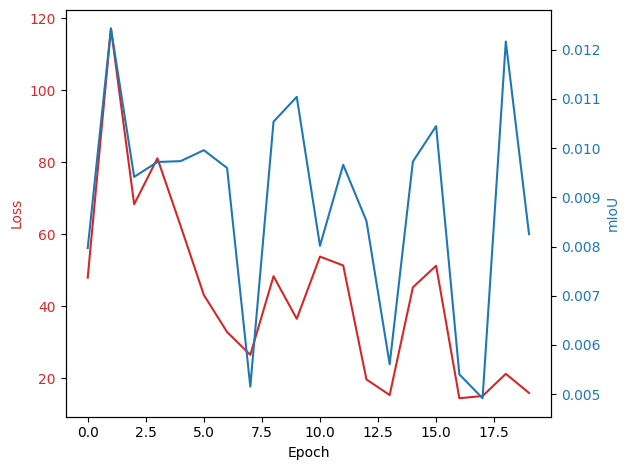

Training epoch 20


100%|██████████| 75/75 [00:27<00:00,  2.68batch/s, loss=19.6]


- Log loss: 30.932912826538086
- mIoU: 0.008904645219445229
Training epoch 21


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=20]  


- Log loss: 88.07954406738281
- mIoU: 0.009602413512766361
Training epoch 22


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=11.4]


- Log loss: 15.38092041015625
- mIoU: 0.007693248335272074
Training epoch 23


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=12.4]


- Log loss: 20.437946319580078
- mIoU: 0.010945439338684082
Training epoch 24


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=22.6]


- Log loss: 36.29157257080078
- mIoU: 0.010512100532650948
Training epoch 25


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=14.4]


- Log loss: 21.233154296875
- mIoU: 0.009709213860332966
Training epoch 26


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=9.25]


- Log loss: 39.40524673461914
- mIoU: 0.011791030876338482
Training epoch 27


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=11.8]


- Log loss: 20.60302734375
- mIoU: 0.007646069396287203
Training epoch 28


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=8.29]


- Log loss: 22.708005905151367
- mIoU: 0.010375702753663063
Training epoch 29


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=54.8]


- Log loss: 30.73826789855957
- mIoU: 0.009034194052219391
Training epoch 30


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=12.7]


- Log loss: 22.878599166870117
- mIoU: 0.008504340425133705
Training epoch 31


100%|██████████| 75/75 [00:35<00:00,  2.11batch/s, loss=10.4]


- Log loss: 36.21015548706055
- mIoU: 0.007839466445147991
Training epoch 32


100%|██████████| 75/75 [00:30<00:00,  2.44batch/s, loss=43.7]


- Log loss: 50.3096809387207
- mIoU: 0.009467345662415028
Training epoch 33


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=10]  


- Log loss: 60.588985443115234
- mIoU: 0.007506625261157751
Training epoch 34


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=9.58]


- Log loss: 32.63420486450195
- mIoU: 0.008800835348665714
Training epoch 35


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=8.54]


- Log loss: 8.33970832824707
- mIoU: 0.006217858288437128
Training epoch 36


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=8.81]


- Log loss: 33.29872131347656
- mIoU: 0.009564146399497986
Training epoch 37


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=11.8]


- Log loss: 17.87217903137207
- mIoU: 0.006277967244386673
Training epoch 38


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=9.23]


- Log loss: 21.018564224243164
- mIoU: 0.007300623692572117
Training epoch 39


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=15.8]


- Log loss: 36.79389190673828
- mIoU: 0.008219101466238499


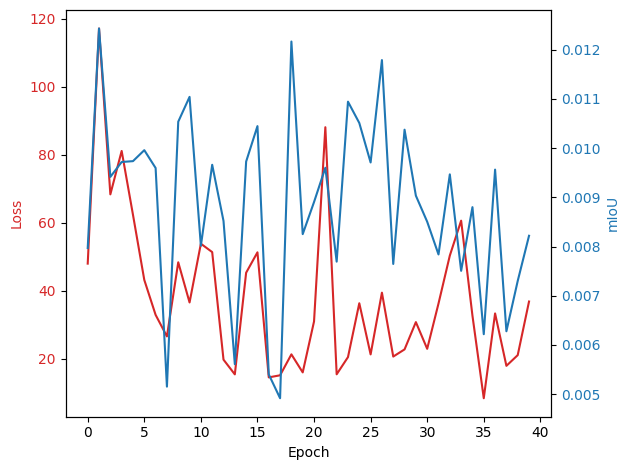

Training epoch 40


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=5.29]


- Log loss: 40.47914505004883
- mIoU: 0.006908446550369263
Training epoch 41


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=4.86]


- Log loss: 31.72535514831543
- mIoU: 0.009105633944272995
Training epoch 42


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=6.96]


- Log loss: 15.498507499694824
- mIoU: 0.00693568354472518
Training epoch 43


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=15]  


- Log loss: 22.429899215698242
- mIoU: 0.008074060082435608
Training epoch 44


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=19.1]


- Log loss: 26.620248794555664
- mIoU: 0.008787034079432487
Training epoch 45


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=11.3]


- Log loss: 31.549762725830078
- mIoU: 0.008196546696126461
Training epoch 46


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=34.8]


- Log loss: 20.218175888061523
- mIoU: 0.008662876673042774
Training epoch 47


100%|██████████| 75/75 [00:30<00:00,  2.46batch/s, loss=5.01]


- Log loss: 19.268707275390625
- mIoU: 0.009115946479141712
Training epoch 48


100%|██████████| 75/75 [00:29<00:00,  2.52batch/s, loss=7.07]


- Log loss: 16.02187156677246
- mIoU: 0.007522489409893751
Training epoch 49


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=24.1]


- Log loss: 14.903467178344727
- mIoU: 0.008268896490335464
Training epoch 50


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=11.8]


- Log loss: 21.232275009155273
- mIoU: 0.008030451834201813
Training epoch 51


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=24.3]


- Log loss: 19.508779525756836
- mIoU: 0.008385908789932728
Training epoch 52


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=13.3]


- Log loss: 20.763553619384766
- mIoU: 0.008941376581788063
Training epoch 53


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=2.4] 


- Log loss: 27.552099227905273
- mIoU: 0.008757280185818672
Training epoch 54


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=25.1]


- Log loss: 18.362228393554688
- mIoU: 0.00786581076681614
Training epoch 55


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=4.28]


- Log loss: 20.27457618713379
- mIoU: 0.007805732544511557
Training epoch 56


100%|██████████| 75/75 [00:33<00:00,  2.25batch/s, loss=4.11]


- Log loss: 12.838944435119629
- mIoU: 0.008282260969281197
Training epoch 57


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=7.3] 


- Log loss: 21.641794204711914
- mIoU: 0.00991346500813961
Training epoch 58


100%|██████████| 75/75 [00:25<00:00,  2.93batch/s, loss=6.29]


- Log loss: 24.865798950195312
- mIoU: 0.00904334057122469
Training epoch 59


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=17.4]


- Log loss: 20.54131507873535
- mIoU: 0.009879795834422112


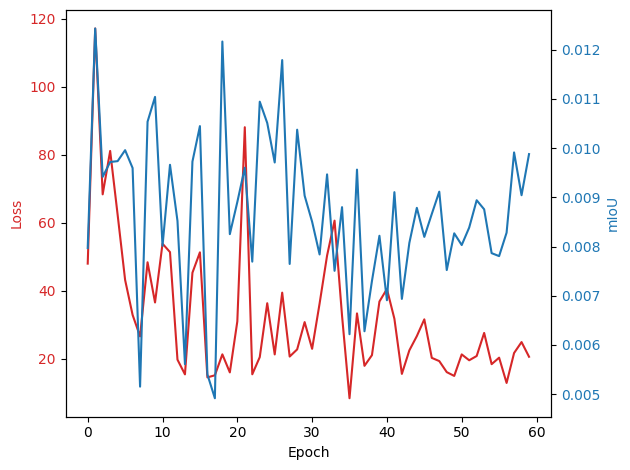

Training epoch 60


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=5.98]


- Log loss: 26.729536056518555
- mIoU: 0.010537111200392246
Training epoch 61


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=5.38]


- Log loss: 15.312580108642578
- mIoU: 0.008962668478488922
Training epoch 62


100%|██████████| 75/75 [00:25<00:00,  2.93batch/s, loss=8.06]


- Log loss: 18.183090209960938
- mIoU: 0.00818411260843277
Training epoch 63


100%|██████████| 75/75 [00:25<00:00,  2.95batch/s, loss=4.14]


- Log loss: 24.104562759399414
- mIoU: 0.0090847322717309
Training epoch 64


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=2.37]


- Log loss: 16.788278579711914
- mIoU: 0.009332118555903435
Training epoch 65


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=4.38]


- Log loss: 20.943971633911133
- mIoU: 0.0090971440076828
Training epoch 66


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=10.9]


- Log loss: 13.365592002868652
- mIoU: 0.00905122421681881
Training epoch 67


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=4.04]


- Log loss: 11.444221496582031
- mIoU: 0.007864697836339474
Training epoch 68


100%|██████████| 75/75 [00:25<00:00,  2.92batch/s, loss=5.55]


- Log loss: 19.474027633666992
- mIoU: 0.007786998525261879
Training epoch 69


100%|██████████| 75/75 [00:25<00:00,  2.93batch/s, loss=10.5]


- Log loss: 11.623482704162598
- mIoU: 0.006917716935276985
Training epoch 70


100%|██████████| 75/75 [00:25<00:00,  2.96batch/s, loss=3.65]


- Log loss: 22.875375747680664
- mIoU: 0.008344994857907295
Training epoch 71


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=8.64]


- Log loss: 16.993366241455078
- mIoU: 0.010300743393599987
Training epoch 72


100%|██████████| 75/75 [00:25<00:00,  2.96batch/s, loss=4.96]


- Log loss: 17.838260650634766
- mIoU: 0.009140389040112495
Training epoch 73


100%|██████████| 75/75 [00:25<00:00,  2.95batch/s, loss=7.02]


- Log loss: 19.613677978515625
- mIoU: 0.007620577234774828
Training epoch 74


100%|██████████| 75/75 [00:25<00:00,  2.95batch/s, loss=12.5]


- Log loss: 18.547277450561523
- mIoU: 0.008673906326293945
Training epoch 75


100%|██████████| 75/75 [00:31<00:00,  2.37batch/s, loss=15.1]


- Log loss: 21.314409255981445
- mIoU: 0.008611434139311314
Training epoch 76


100%|██████████| 75/75 [00:35<00:00,  2.11batch/s, loss=15.3]


- Log loss: 24.779733657836914
- mIoU: 0.008147215470671654
Training epoch 77


100%|██████████| 75/75 [00:33<00:00,  2.26batch/s, loss=17.8]


- Log loss: 12.019810676574707
- mIoU: 0.00804909598082304
Training epoch 78


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=5.57]


- Log loss: 11.341636657714844
- mIoU: 0.008228733204305172
Training epoch 79


100%|██████████| 75/75 [00:25<00:00,  2.91batch/s, loss=2.65]


- Log loss: 23.08454704284668
- mIoU: 0.009440195746719837


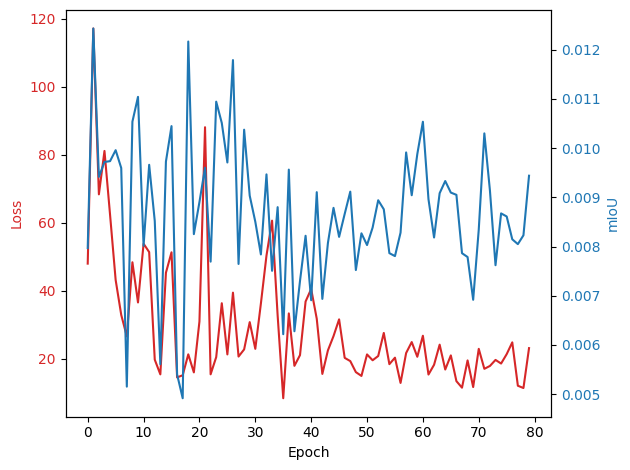

Training epoch 80


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=7.24]


- Log loss: 21.375051498413086
- mIoU: 0.007065412122756243
Training epoch 81


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=6.37]


- Log loss: 17.37297821044922
- mIoU: 0.009213908575475216
Training epoch 82


100%|██████████| 75/75 [00:25<00:00,  2.90batch/s, loss=7.39]


- Log loss: 19.99099349975586
- mIoU: 0.008093050681054592
Training epoch 83


100%|██████████| 75/75 [00:25<00:00,  2.93batch/s, loss=15.5]


- Log loss: 7.149839401245117
- mIoU: 0.006445559673011303
Training epoch 84


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=9.87]


- Log loss: 21.258432388305664
- mIoU: 0.009150322526693344
Training epoch 85


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=18.8]


- Log loss: 19.622106552124023
- mIoU: 0.006809441838413477
Training epoch 86


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=9.03]


- Log loss: 12.879781723022461
- mIoU: 0.007730113808065653
Training epoch 87


100%|██████████| 75/75 [00:30<00:00,  2.48batch/s, loss=12.1]


- Log loss: 11.006009101867676
- mIoU: 0.007915637455880642
Training epoch 88


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=16.1]


- Log loss: 18.238330841064453
- mIoU: 0.007205620873719454
Training epoch 89


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=5.99]


- Log loss: 11.805041313171387
- mIoU: 0.007531973998993635
Training epoch 90


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=3.06]


- Log loss: 20.906042098999023
- mIoU: 0.007915330119431019
Training epoch 91


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=16.5]


- Log loss: 23.513687133789062
- mIoU: 0.008322224952280521
Training epoch 92


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=17.6]


- Log loss: 27.335777282714844
- mIoU: 0.008430364541709423
Training epoch 93


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=10.1]


- Log loss: 21.462337493896484
- mIoU: 0.008118562400341034
Training epoch 94


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=8.28]


- Log loss: 7.791522026062012
- mIoU: 0.006514814216643572
Training epoch 95


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=16]  


- Log loss: 16.832828521728516
- mIoU: 0.009363397024571896
Training epoch 96


100%|██████████| 75/75 [00:27<00:00,  2.73batch/s, loss=6.71]


- Log loss: 16.444929122924805
- mIoU: 0.009563318453729153
Training epoch 97


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=12.3]


- Log loss: 19.9366397857666
- mIoU: 0.00903309602290392
Training epoch 98


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=10.9]


- Log loss: 14.083348274230957
- mIoU: 0.007843268103897572
Training epoch 99


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=8.11]


- Log loss: 20.443307876586914
- mIoU: 0.00747027900069952


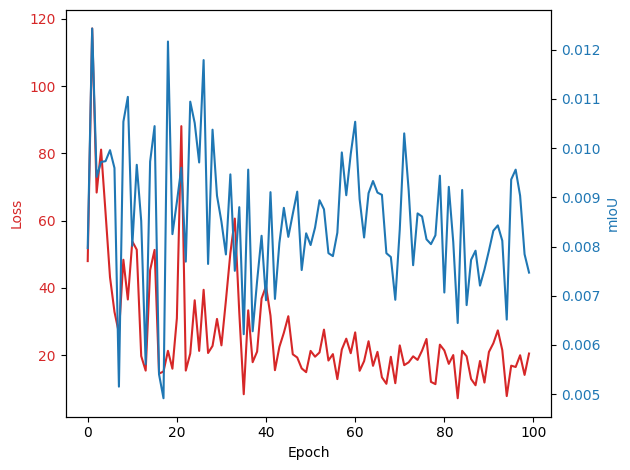

Training epoch 100


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=21.3]


- Log loss: 11.973657608032227
- mIoU: 0.008558985777199268
Training epoch 101


100%|██████████| 75/75 [00:25<00:00,  2.92batch/s, loss=17.5]


- Log loss: 16.307540893554688
- mIoU: 0.008932912722229958
Training epoch 102


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=3.38]


- Log loss: 7.909820556640625
- mIoU: 0.006014314014464617
Training epoch 103


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=13.9]


- Log loss: 16.751367568969727
- mIoU: 0.009197008796036243
Training epoch 104


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=10.3]


- Log loss: 12.924018859863281
- mIoU: 0.009081428870558739
Training epoch 105


100%|██████████| 75/75 [00:29<00:00,  2.54batch/s, loss=15.5]


- Log loss: 18.597957611083984
- mIoU: 0.008203648030757904
Training epoch 106


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=9.27]


- Log loss: 10.740147590637207
- mIoU: 0.006765460129827261
Training epoch 107


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=16.9]


- Log loss: 21.024791717529297
- mIoU: 0.009005778469145298
Training epoch 108


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=4.33]


- Log loss: 28.304962158203125
- mIoU: 0.009336168877780437
Training epoch 109


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=5.67]


- Log loss: 18.992799758911133
- mIoU: 0.008689655922353268
Training epoch 110


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=4.74]


- Log loss: 30.927549362182617
- mIoU: 0.00852799043059349
Training epoch 111


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=7.2] 


- Log loss: 11.516958236694336
- mIoU: 0.008086293935775757
Training epoch 112


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=15.5]


- Log loss: 17.219423294067383
- mIoU: 0.00889156199991703
Training epoch 113


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=7.02]


- Log loss: 18.69381332397461
- mIoU: 0.00825587660074234
Training epoch 114


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=3.68]


- Log loss: 10.013026237487793
- mIoU: 0.008074010722339153
Training epoch 115


100%|██████████| 75/75 [00:27<00:00,  2.78batch/s, loss=13.5]


- Log loss: 11.747776985168457
- mIoU: 0.006902268622070551
Training epoch 116


100%|██████████| 75/75 [00:25<00:00,  2.93batch/s, loss=13.1]


- Log loss: 15.204991340637207
- mIoU: 0.008905761875212193
Training epoch 117


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=3.59]


- Log loss: 24.41747283935547
- mIoU: 0.009552288800477982
Training epoch 118


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=10.6]


- Log loss: 5.880220413208008
- mIoU: 0.0052865128964185715
Training epoch 119


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=18.4]


- Log loss: 6.497251510620117
- mIoU: 0.006359882187098265


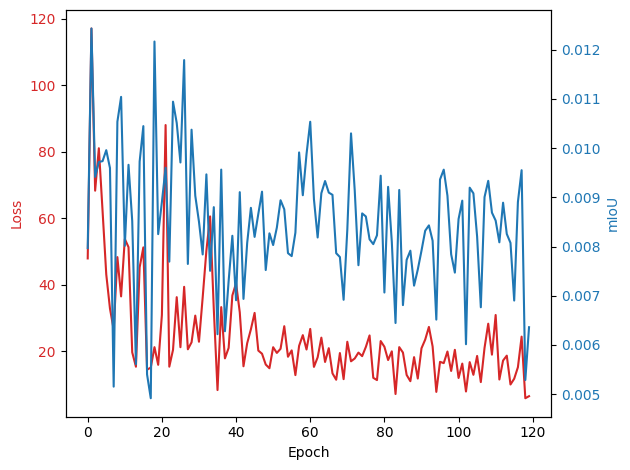

Training epoch 120


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=10.1]


- Log loss: 21.576257705688477
- mIoU: 0.008464505895972252
Training epoch 121


100%|██████████| 75/75 [00:25<00:00,  2.91batch/s, loss=2.48]


- Log loss: 13.895350456237793
- mIoU: 0.00931312795728445
Training epoch 122


100%|██████████| 75/75 [00:25<00:00,  2.91batch/s, loss=11.9]


- Log loss: 9.577720642089844
- mIoU: 0.008201847784221172
Training epoch 123


100%|██████████| 75/75 [00:25<00:00,  2.92batch/s, loss=14]  


- Log loss: 10.233599662780762
- mIoU: 0.007745909038931131
Training epoch 124


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=7.49]


- Log loss: 12.857959747314453
- mIoU: 0.00854240171611309
Training epoch 125


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=16]  


- Log loss: 17.814085006713867
- mIoU: 0.009591647423803806
Training epoch 126


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=5.86]


- Log loss: 22.956531524658203
- mIoU: 0.007845085114240646
Training epoch 127


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=9.29]


- Log loss: 14.931421279907227
- mIoU: 0.009180713444948196
Training epoch 128


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=13.8]


- Log loss: 16.259824752807617
- mIoU: 0.008693003095686436
Training epoch 129


100%|██████████| 75/75 [00:30<00:00,  2.46batch/s, loss=3.96]


- Log loss: 12.186539649963379
- mIoU: 0.007341035641729832
Training epoch 130


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=5.47]


- Log loss: 24.91977882385254
- mIoU: 0.0076766046695411205
Training epoch 131


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=5.81]


- Log loss: 29.54546546936035
- mIoU: 0.009083800949156284
Training epoch 132


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=24.6]


- Log loss: 9.981732368469238
- mIoU: 0.008153135888278484
Training epoch 133


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=16]  


- Log loss: 10.672876358032227
- mIoU: 0.008139058947563171
Training epoch 134


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=13.2]


- Log loss: 33.02064895629883
- mIoU: 0.00877321232110262
Training epoch 135


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=4.48]


- Log loss: 15.465042114257812
- mIoU: 0.008581746369600296
Training epoch 136


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=10.3]


- Log loss: 12.176334381103516
- mIoU: 0.006127931177616119
Training epoch 137


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=13.4]


- Log loss: 27.36457633972168
- mIoU: 0.008458659052848816
Training epoch 138


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=4.23]


- Log loss: 12.034761428833008
- mIoU: 0.007855817675590515
Training epoch 139


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=38.1]


- Log loss: 19.60094451904297
- mIoU: 0.008806170895695686


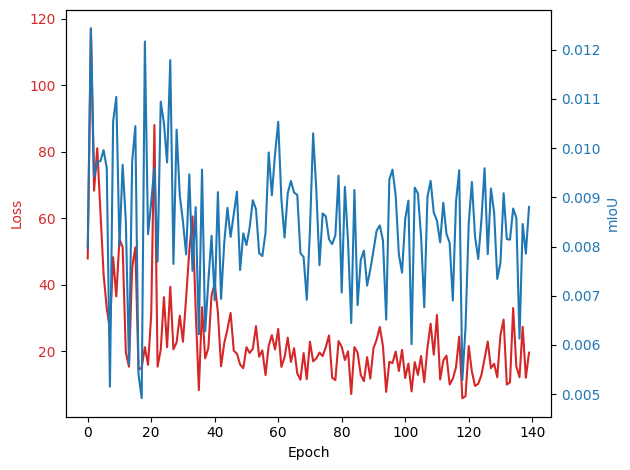

Training epoch 140


100%|██████████| 75/75 [00:25<00:00,  2.95batch/s, loss=19.4]


- Log loss: 19.160825729370117
- mIoU: 0.009407185949385166
Training epoch 141


100%|██████████| 75/75 [00:25<00:00,  2.92batch/s, loss=12.3]


- Log loss: 18.13918113708496
- mIoU: 0.008147014304995537
Training epoch 142


100%|██████████| 75/75 [00:25<00:00,  2.94batch/s, loss=10.7]


- Log loss: 16.844636917114258
- mIoU: 0.00975105445832014
Training epoch 143


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=7.13]


- Log loss: 15.330290794372559
- mIoU: 0.007625589147210121
Training epoch 144


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=3.48]


- Log loss: 8.778851509094238
- mIoU: 0.007511037401854992
Training epoch 145


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=37.6]


- Log loss: 6.270956993103027
- mIoU: 0.004723013378679752
Training epoch 146


100%|██████████| 75/75 [00:25<00:00,  2.90batch/s, loss=6.52]


- Log loss: 9.284887313842773
- mIoU: 0.0060776108875870705
Training epoch 147


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=3.91]


- Log loss: 23.190671920776367
- mIoU: 0.010425086133182049
Training epoch 148


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=6.29]


- Log loss: 16.622455596923828
- mIoU: 0.008489646017551422
Training epoch 149


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=2.1] 


- Log loss: 21.07448959350586
- mIoU: 0.007561525329947472


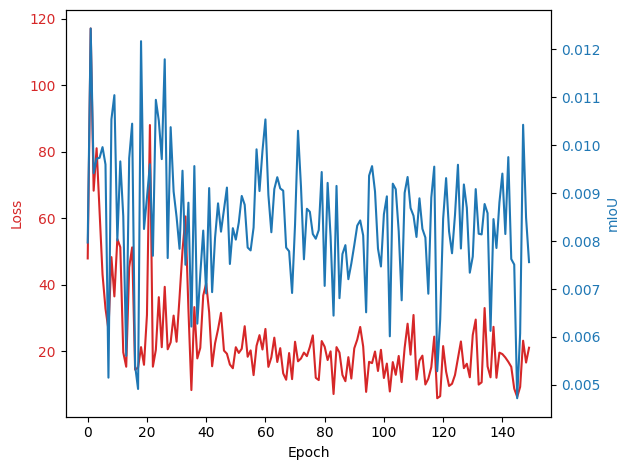

Training complete!


In [10]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
# loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])
loss_fn = HausdorffDT_Focal_Loss(focal_weight = 0.65)

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=150)

In [11]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [12]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [13]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  118


/tmp/ipykernel_36/1094549648.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(in_dir+"final_model",


In [14]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out).unsqueeze(0), np.squeeze(batch["target"]).unsqueeze(0))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:34<00:00,  7.30it/s]

Mean Loss: 66.5984
Mean IoU: 0.4586
Mean Accuracy: 0.9497
Mean Recall: 0.5186
Mean False Positive Rate: 0.0326
Mean False Negative Rate: 0.9954


pos
1.6181229747279564e-07


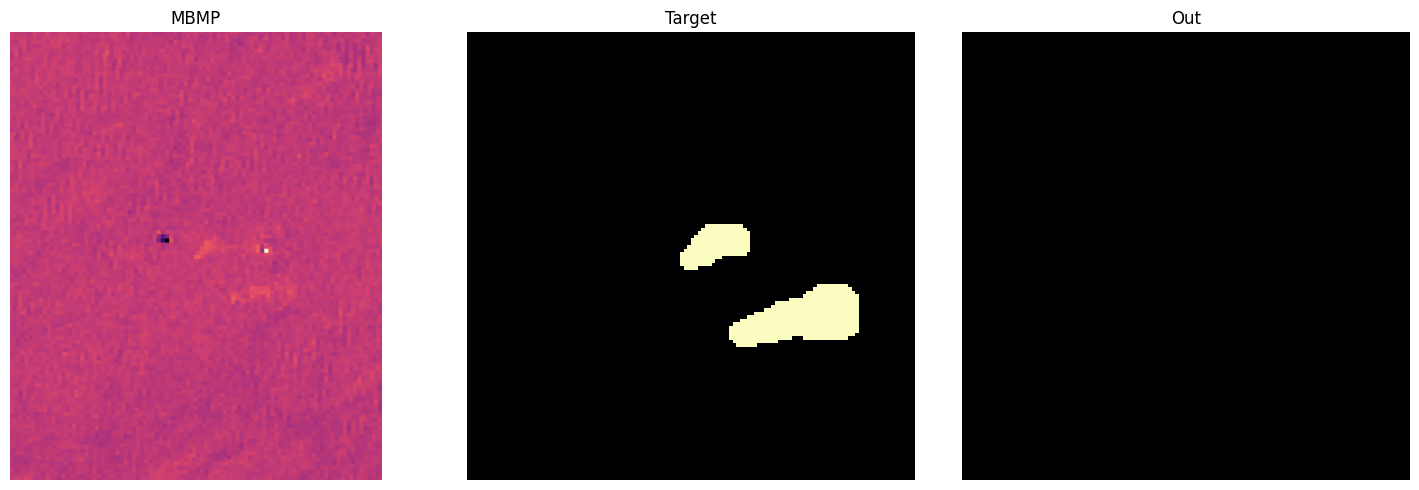

pos
6.622516512433665e-07


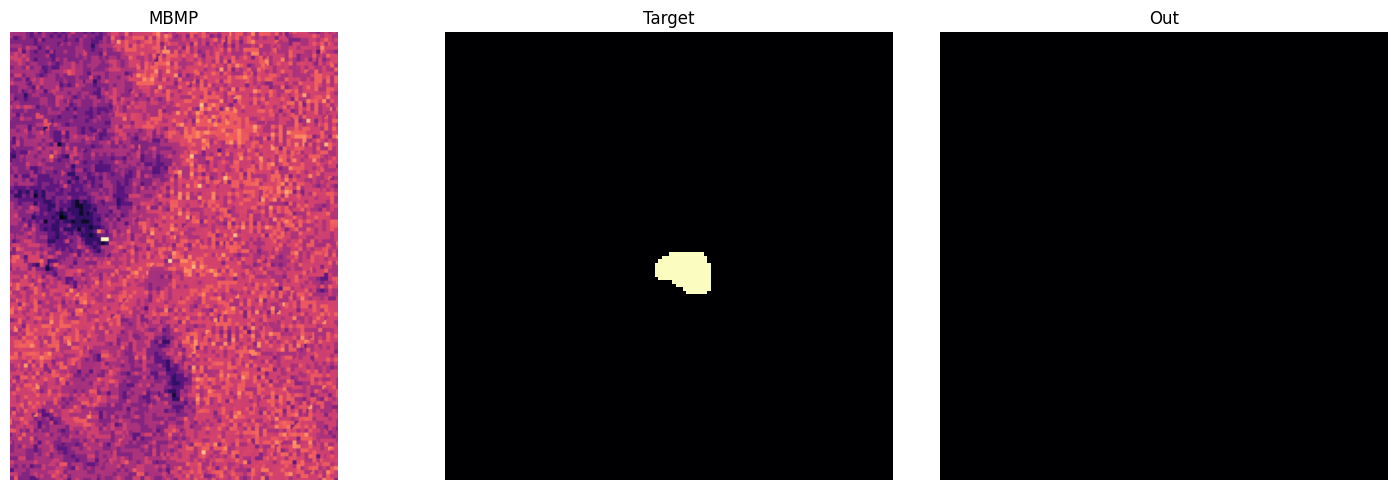

pos
2.3752969064719786e-07


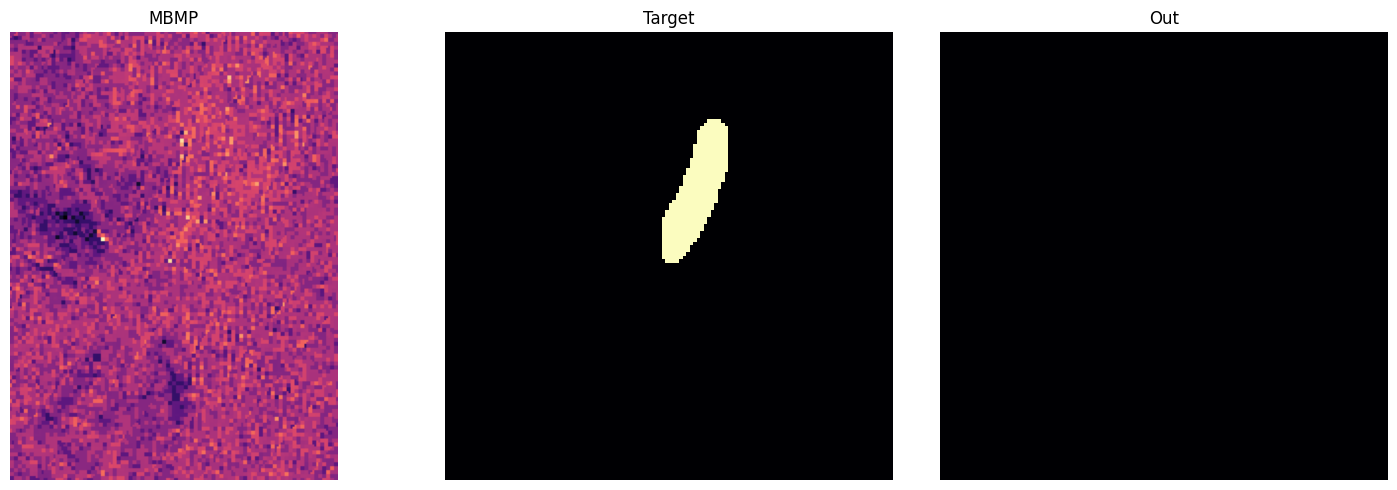

pos
1.9841269801902244e-07


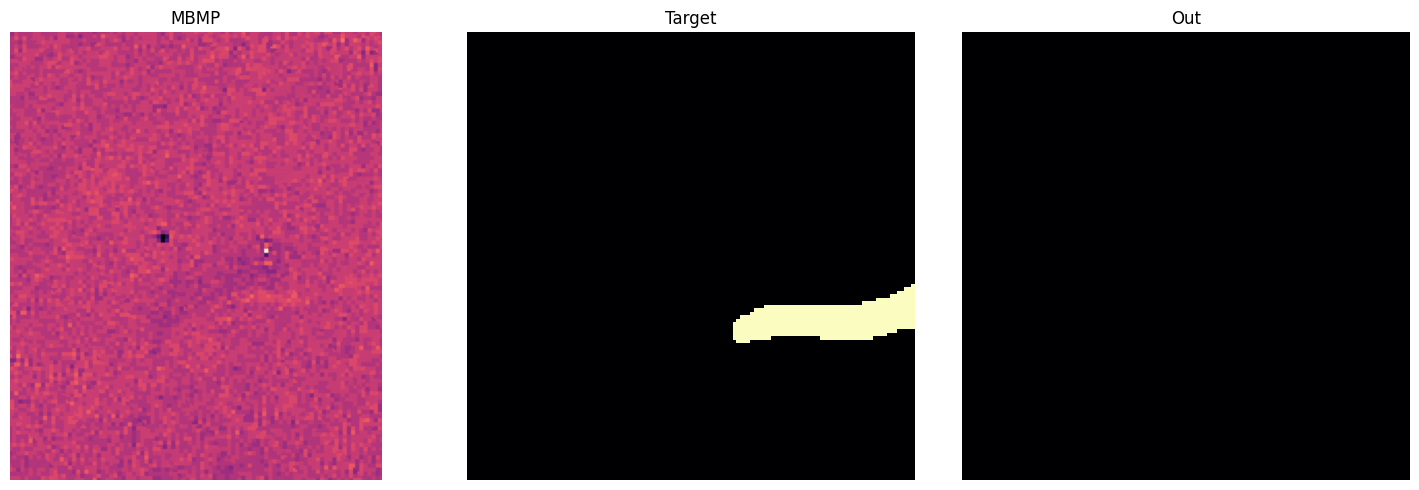

neg
100.0


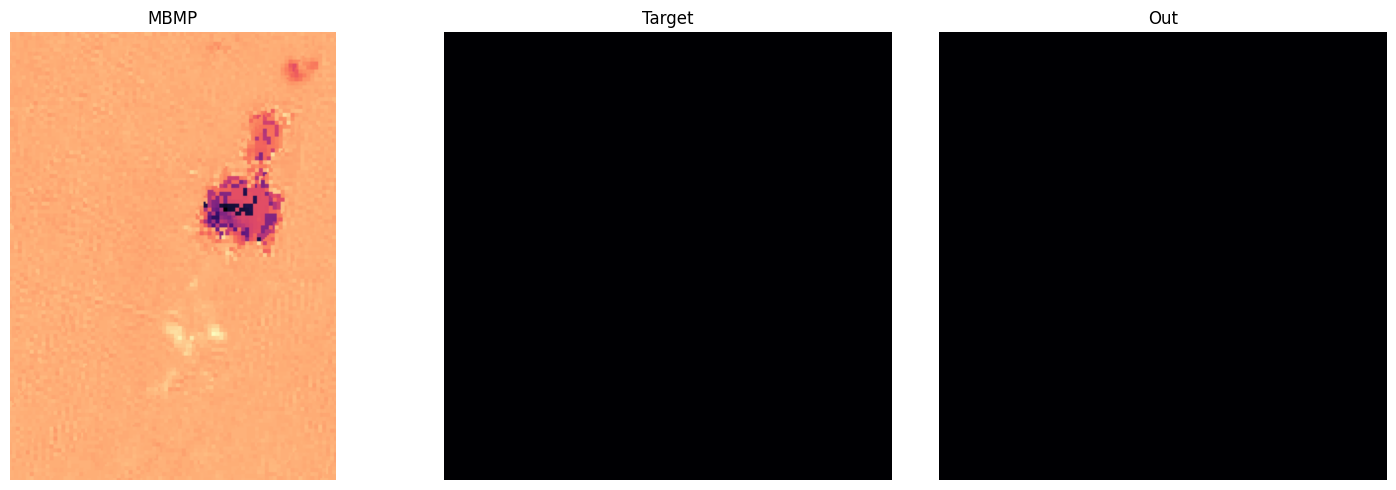

neg
100.0


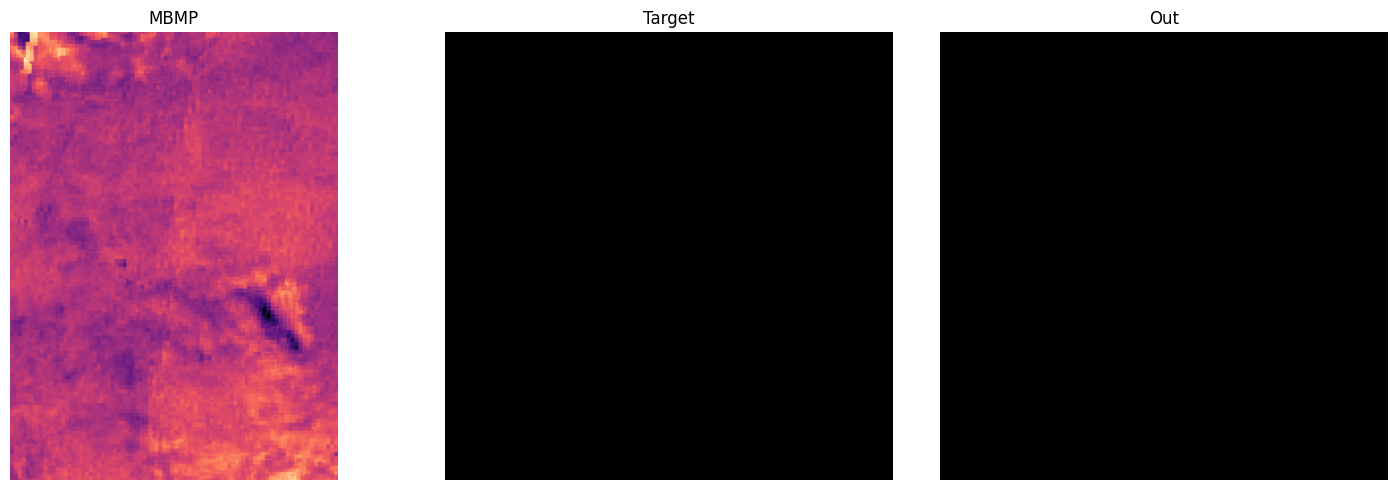

pos
6.622516512433665e-07


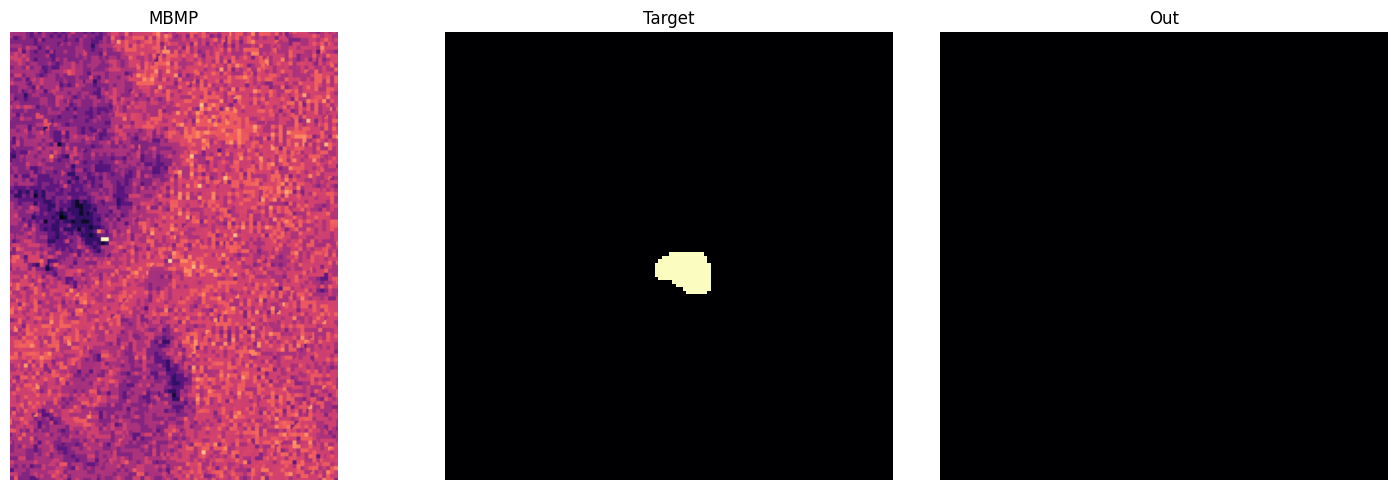

pos
1.4005602221280667e-07


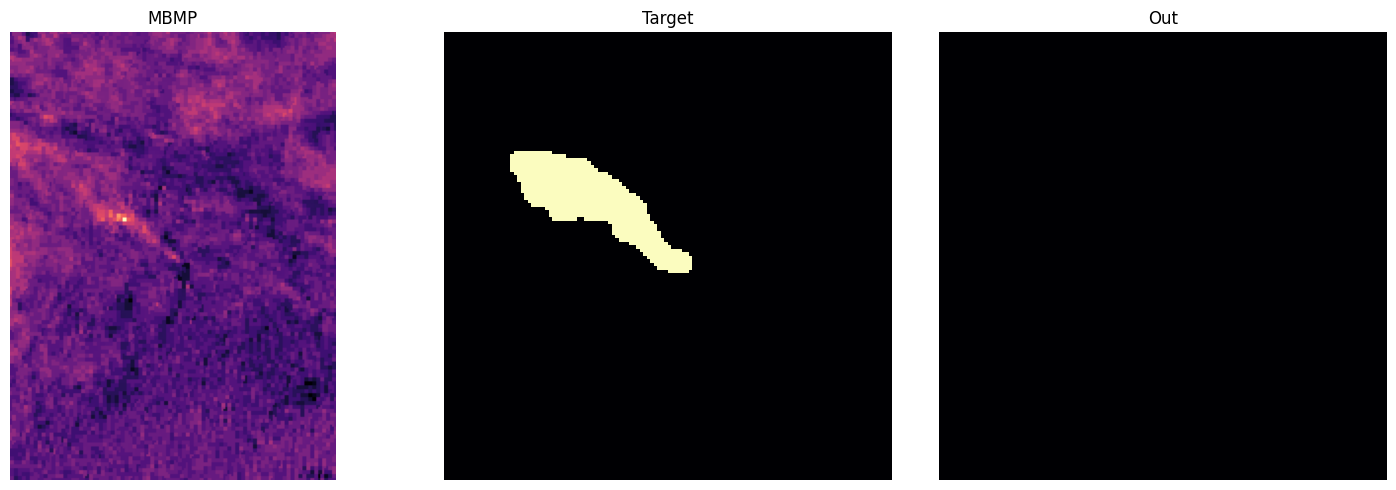

pos
1.6181229747279564e-07


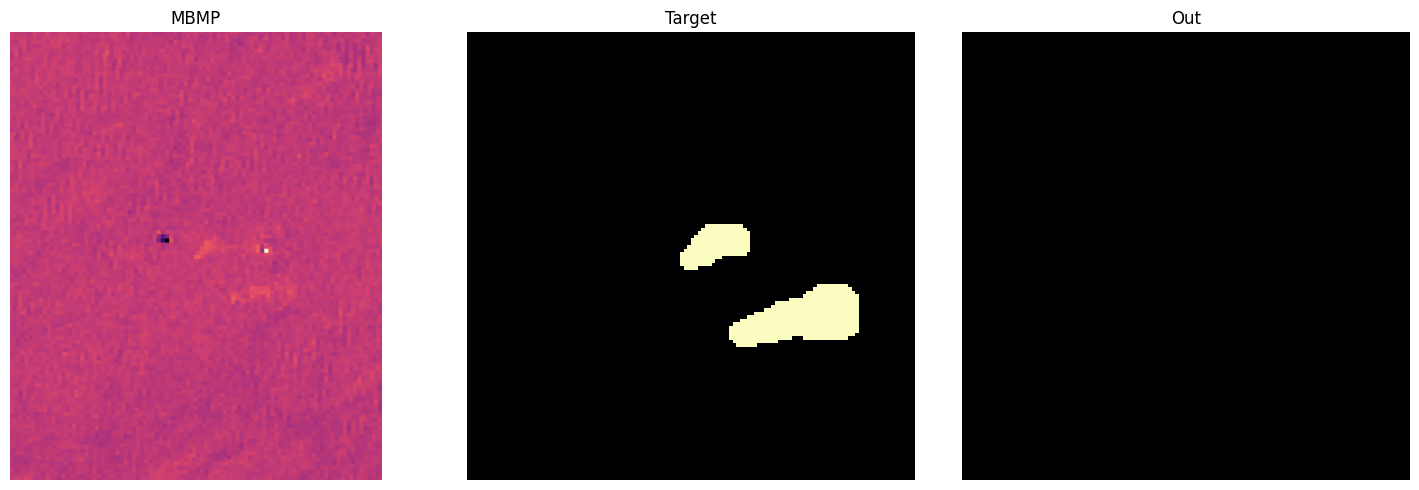

neg
100.0


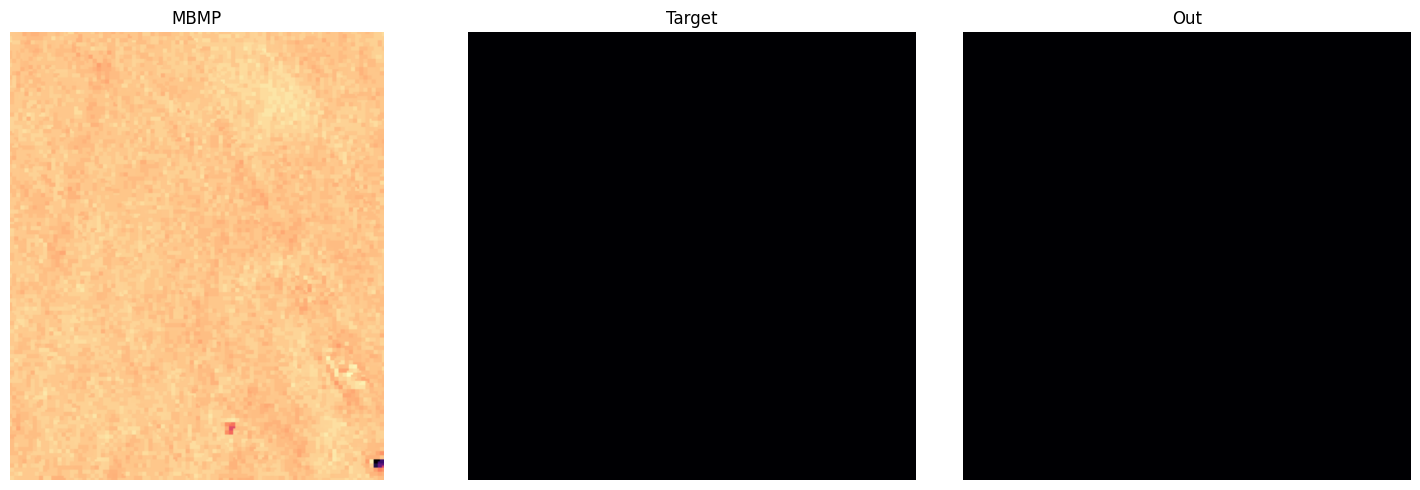

pos
3.4013605326484333e-07


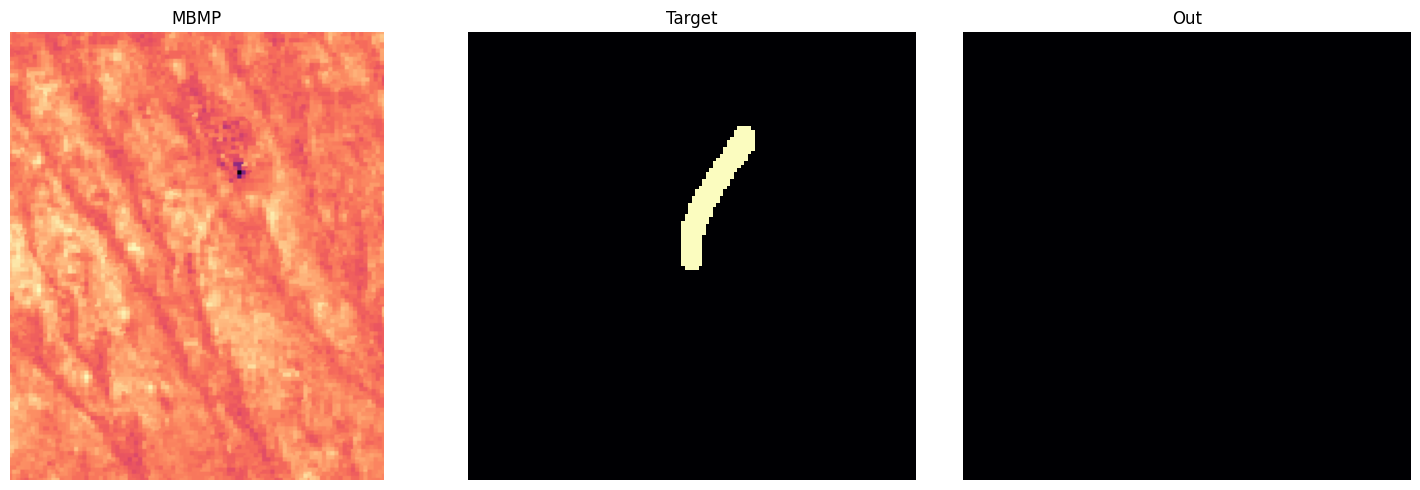

pos
1.5243902415786734e-07


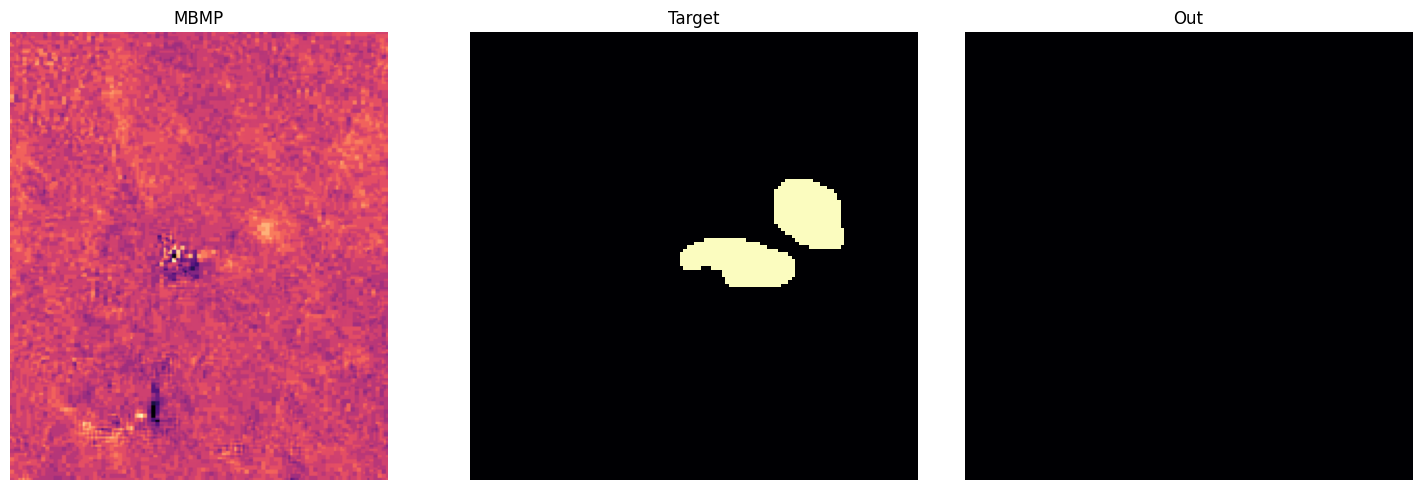

neg
100.0


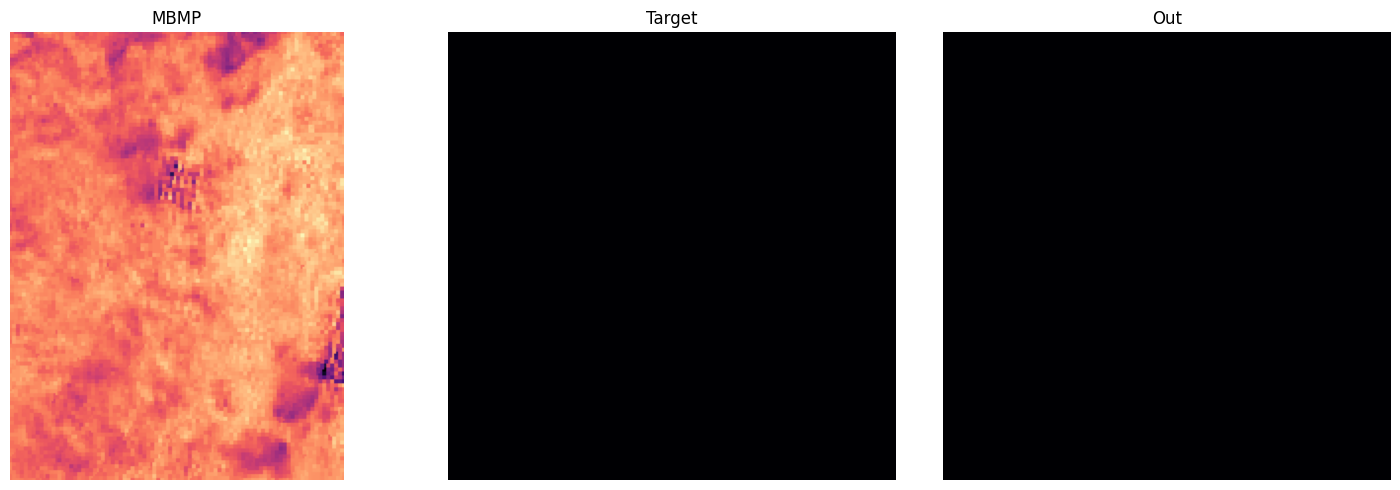

neg
100.0


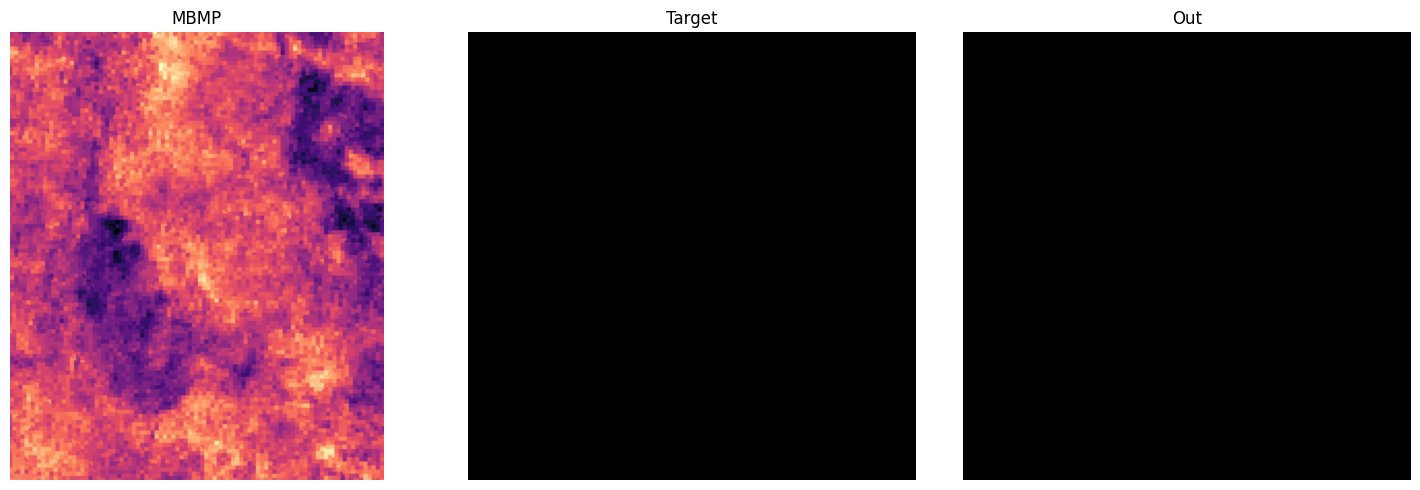

neg
100.0


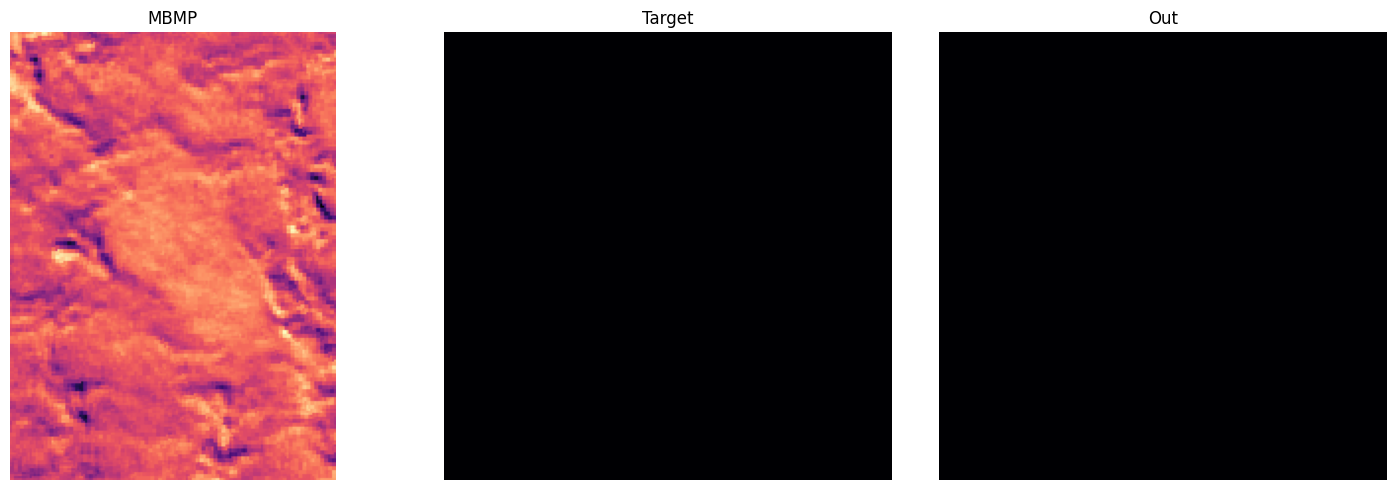

pos
2.1881838026516766e-07


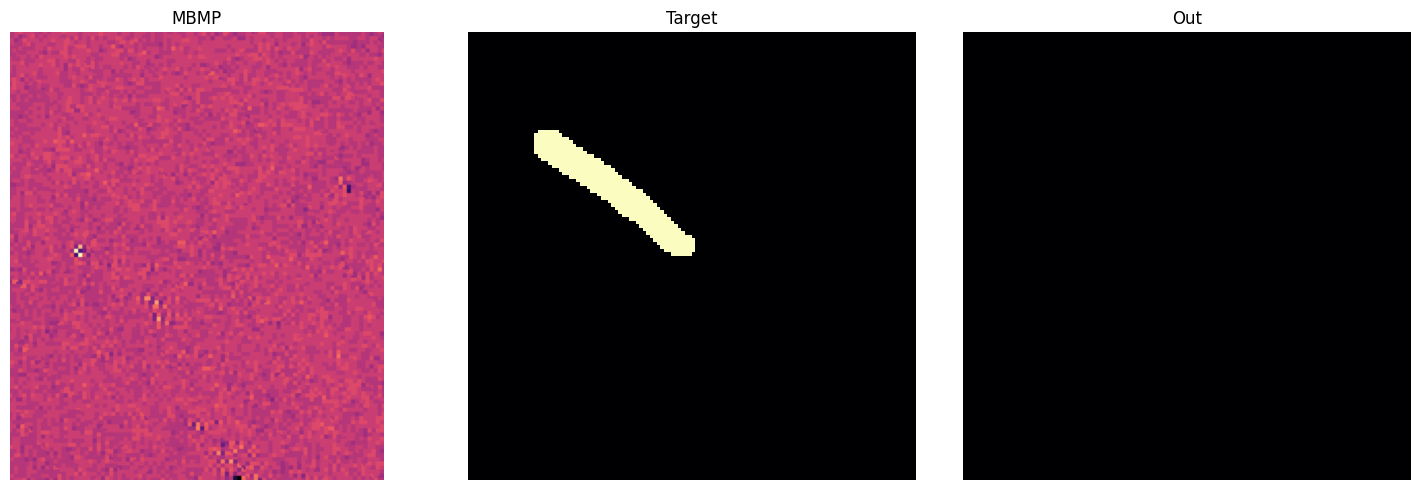

pos
4.34782606805293e-07


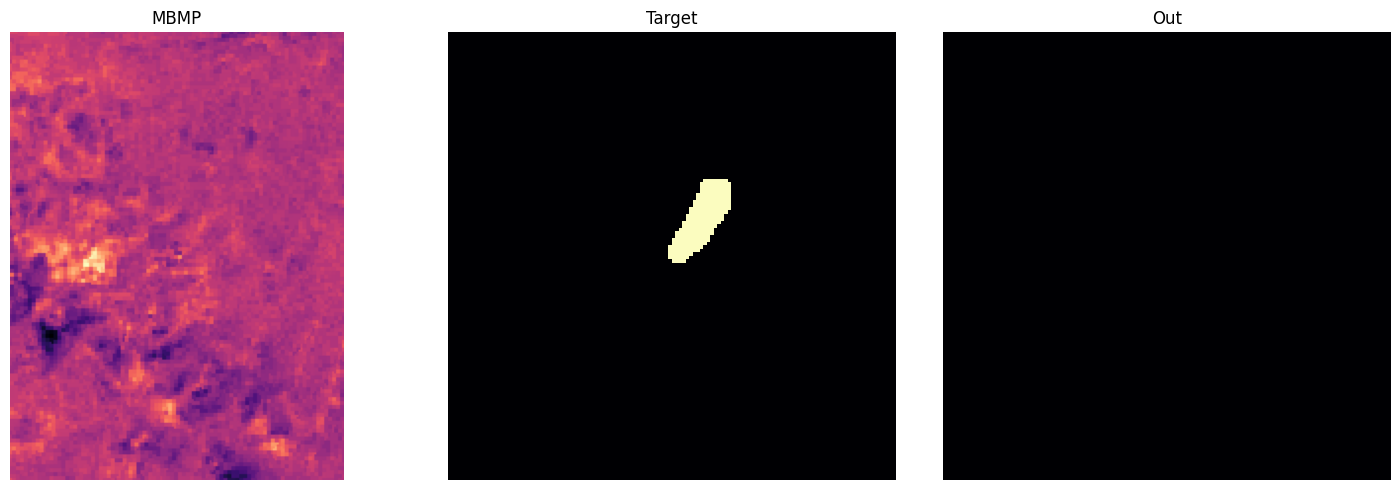

pos
1.4005602221280667e-07


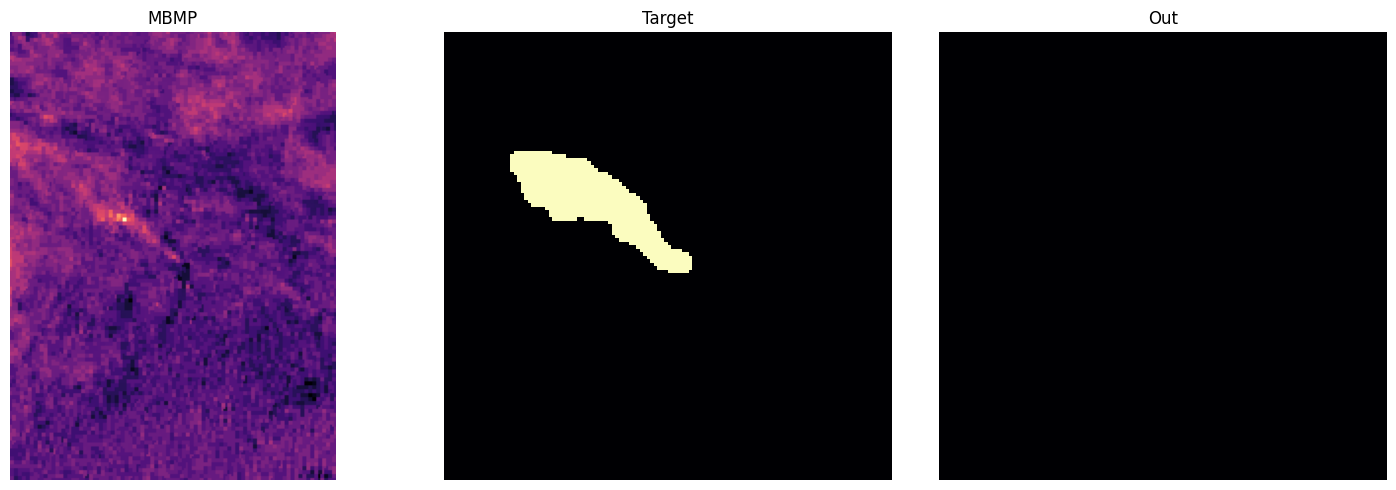

pos
2.985074617955001e-07


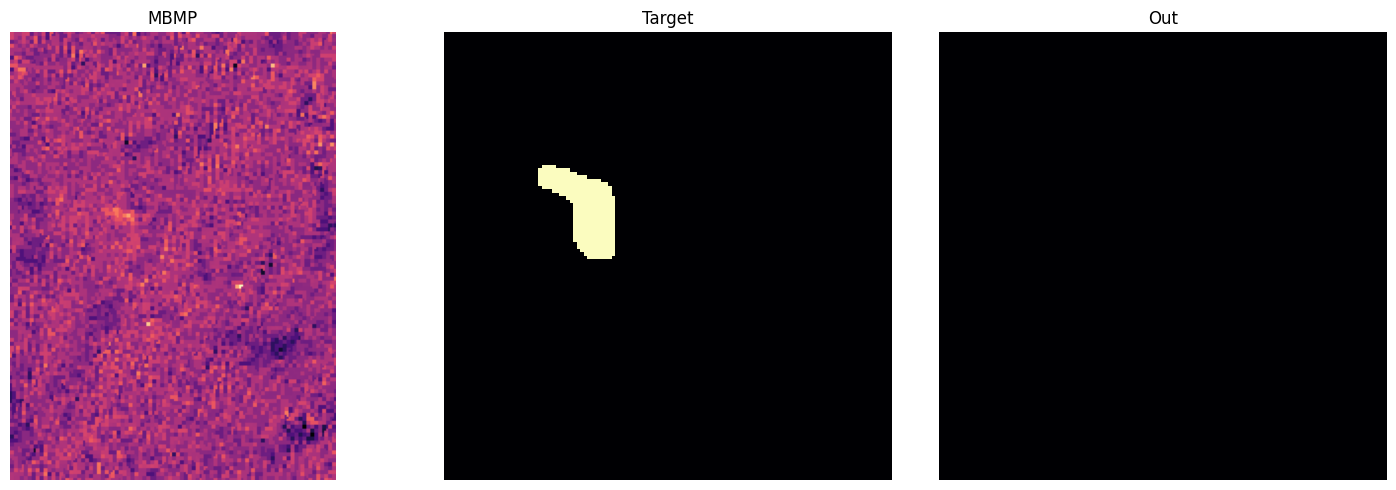

pos
1.6366612084506364e-07


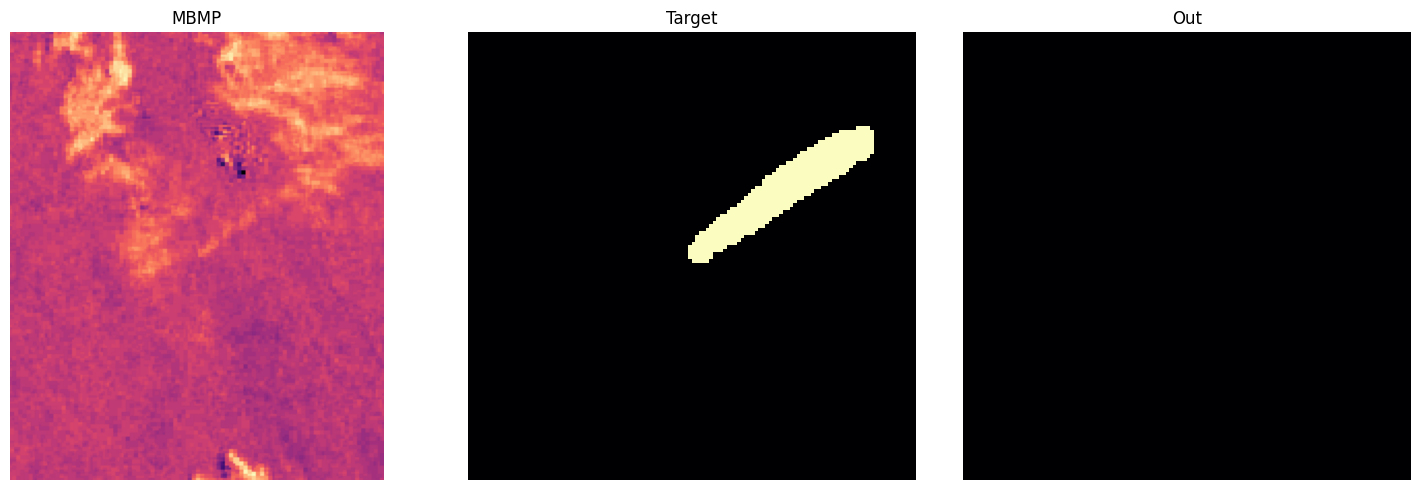

In [16]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==20): break
